# Scoring

The purpose of this notebook is to see how the classifier score variates when the number of features varies.

To test this, two classifiers are created:

- The first classifier uses all the datasets and randomly takes 90% for training and 10% for validation, ignoring temporal consistency. Since the used features vary due to random sampling, the classifier is run multiple times.
- The second classifier uses the first dataset for training and the remaining datasets for validation, enforcing temporal consistency.

In [1]:
import lib.data_loading as jcfg_data_loading
import pandas as pd
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

dataset_name = "dataset"
numb_datasets = 6

datasets = []

# Load all samples with an array, where each ith position are samples
# up to the ith+1 submission of the target sample
for i in range(numb_datasets):
    datasets.append(pd.read_csv(dataset_name + str(i) + '.csv'))
    datasets[i] = datasets[i].set_index('md5')
    datasets[i].dropna(inplace=True, subset=['imports'])
    print('Final {0}th dataset size: {1}'.format(i, len(datasets[i])))
    


Final 0th dataset size: 2798
Final 1th dataset size: 31
Final 2th dataset size: 22
Final 3th dataset size: 121
Final 4th dataset size: 286
Final 5th dataset size: 465


## First classifier

Following is only for code testing, results from multiple runs are available in the images.

In [44]:
# Parameters for the bag of words
# Split by the semicolon
count_vec_pattern = u'[^;]+'
# A call must be present at least in x samples
min_df = 2

# percentage of train and validation
training_size = 0.9
validation_size = 1 - training_size

# Concat the datasets
first_dataset = pd.concat(datasets)

def train_and_test(i):
    # Split the dataset into train & validation
    train_test = train_test_split(first_dataset, test_size=validation_size)

    scores = [0] * len(np.arange(max_df_low, max_df_high, max_df_step))
    for idx, max_df in enumerate(np.arange(max_df_low, max_df_high, max_df_step)):
    # for max_df in np.arange(0.1, 0.12, 0.01):
        # Create the bag of words
        cv = CountVectorizer(token_pattern=count_vec_pattern, max_df=max_df, min_df=min_df)
        # Create the training set
        train_set = [
            cv.fit_transform(train_test[0].imports).toarray(),
            train_test[0].malware.values
        ]
        # Create the validation set
        val_set = [
            cv.transform(train_test[1].imports).toarray(),
            train_test[1].malware.values
        ]
        
        # Create the classifier, train it and score it
        lr = LogisticRegression()
        lr.fit(train_set[0], train_set[1])
        
        lr_score = lr.score(val_set[0], val_set[1])
        scores[idx] += lr_score
    print('Done {0}'.format(i))
    return scores

# Check how we can limit the max_df_high
# test_cv = CountVectorizer(token_pattern=count_vec_pattern, min_df=0.71)
# test_cv.fit_transform(first_dataset.imports)
# test_cv.vocabulary_
# The max_df value is 0.71, there are no calls that appear in more than 71% of samples

Done 0


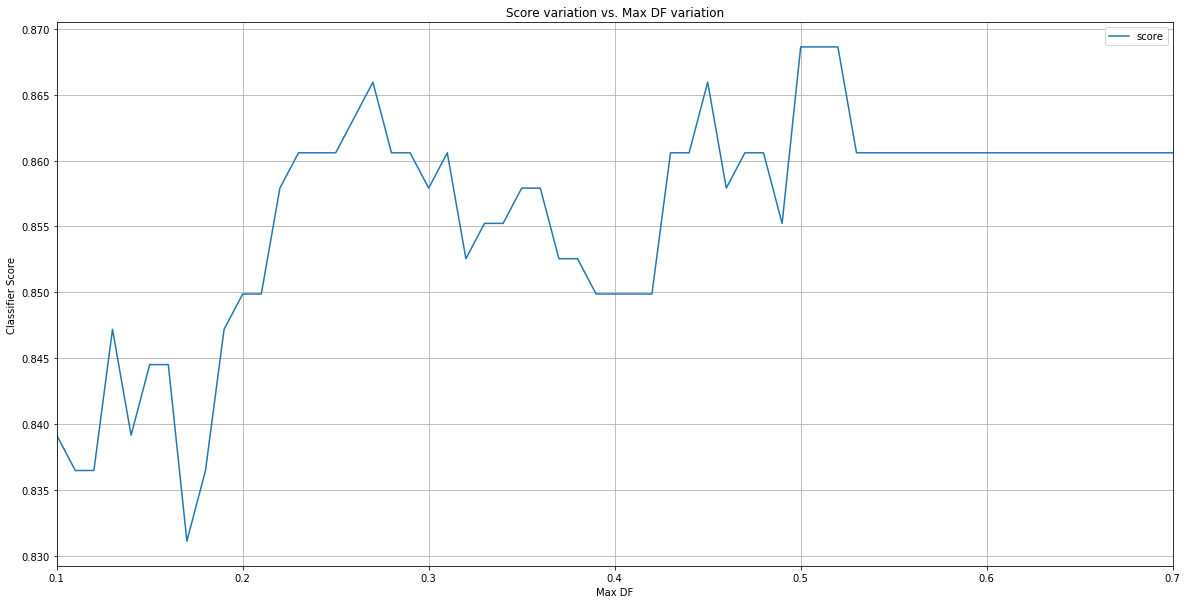

In [35]:
# max_df intervals
max_df_low = 0.1
max_df_high= 0.71
max_df_step= 0.01

tmp = []
for j in range(1000):
    tmp.append(train_and_test(j))

results = pd.DataFrame(data=np.mean([j for j in tmp], axis=0), index=np.arange(max_df_low, max_df_high, max_df_step))
results.columns = ['score']
results.to_csv(path_or_buf='first_classifier.csv')
ax = results.plot(figsize=(20, 10), xticks=np.arange(max_df_low, max_df_high, 0.1), grid=True,
                  title='Score variation w/o temporal consistency')
plt.ylabel('Classifier Score')
plt.xlabel('Max DF')
plt.savefig('first_classifier.png')

## Second classifier

In [20]:
def train_and_test2():
    scores = [0] * len(np.arange(max_df_low, max_df_high, max_df_step))
    
    for idx, max_df in enumerate(np.arange(max_df_low, max_df_high, max_df_step)):
        # Create the bag of words
        cv = CountVectorizer(token_pattern=count_vec_pattern, max_df=max_df, min_df=min_df)
        # Create the training set
        train_set = [
            cv.fit_transform(train_test[0].imports).toarray(),
            train_test[0].malware.values
        ]
        # Create the validation set
        val_set = [
            cv.transform(train_test[1].imports).toarray(),
            train_test[1].malware.values
        ]
        
        # Create the classifier, train it and score it
        lr = LogisticRegression()
        lr.fit(train_set[0], train_set[1])
        
        lr_score = lr.score(val_set[0], val_set[1])
        scores[idx] += lr_score
    return scores

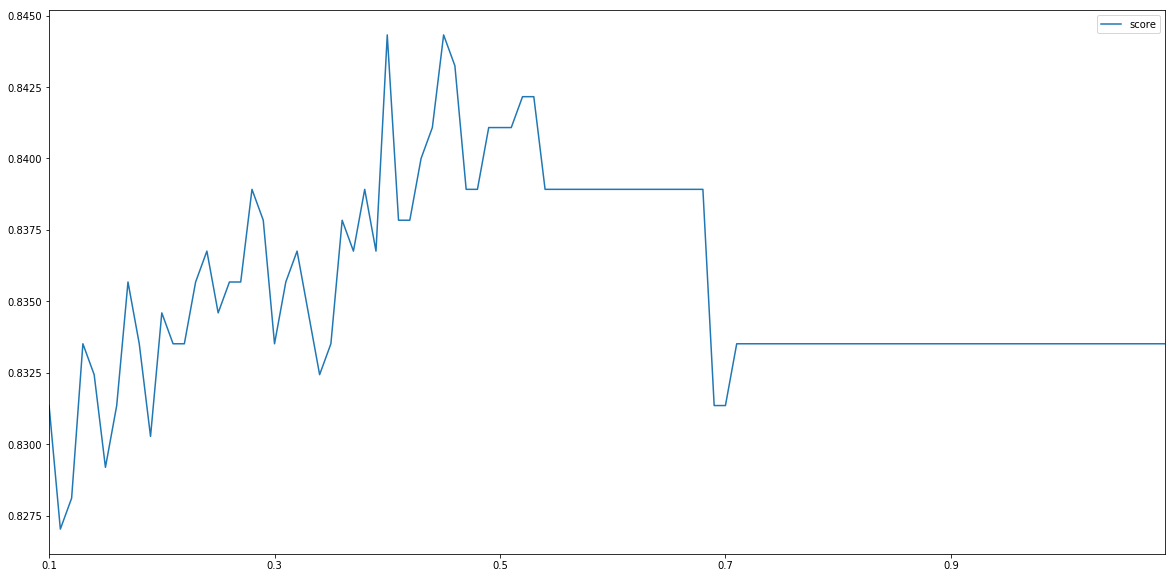

In [21]:
train_test = [datasets[0], pd.concat(datasets[1:])]

# max_df intervals
max_df_low = 0.1
max_df_high= 0.71
max_df_step= 0.01

score = train_and_test2()

results = pd.DataFrame(data=score, index=np.arange(max_df_low, max_df_high, max_df_step))
results.columns = ['score']
results.to_csv(path_or_buf='second_classifier.csv')
ax = results.plot(figsize=(20, 10), xticks=np.arange(max_df_low, max_df_high, 0.1), grid=True,
                  title='Score variation with temporal consistency')
plt.ylabel('Classifier Score')
plt.xlabel('Max DF')
plt.savefig('second_classifier.png')